In [1]:
###################################################################################################
###                             Motif Enrichment                                ###
###################################################################################################

#load libraries
library(tidyverse)
library(devtools)
library(motifmatchr)
library(BiocParallel)
load_all("/home/jpm73279/genome_downloads/BS_genomes/BSgenome.Os")
library(Matrix)
library(GenomicAlignments)
library(dplyr)
library(universalmotif)  # manipulating motif representations
library(nullranges)
genome_bs <- BSgenome.Os


################################
################################
##### LOAD Markers ################
################################

## Load Markers for All Species
marker_file_paths <- c("/home/jpm73279/genome_downloads/C4_markers/Os.c4_markers.bed")

# Function to read and process the file
process_file <- function(file_path) {
  species <- substr(basename(file_path), 1, 2)
  read_delim(file_path, delim = "\t", col_names = c("chrom", "start", "end", "geneID", "name", "type")) %>% 
    dplyr::select("chrom","start","end","geneID","name","type") %>%
    dplyr::mutate(species = (species))
}

# Apply the function to each file and store results in a list
list_of_dataframes <- lapply(marker_file_paths, process_file)

# Optionally combine all dataframes into one if needed
markers <- bind_rows(list_of_dataframes) %>% 
    dplyr::select(geneID,name,type,species) 


################################
################################
##### LOAD ACRS ################
################################
#sb_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/sb_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
#pm_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/pm_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
#acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
#uf_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/uf_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score")) 
os_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/os_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))

################################
################################
##### LOAD Motifs ################
################################

core_motifs <- read_meme("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/00.data/conserved_consensus_motifs_Fig2B.meme")
de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/combined_unique_motifs.meme")
ms_de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/Ms.specific_CGTCGT_motif.comparative.meme")

all_assy_motifs <- c(core_motifs, de_novo_motifs, ms_de_novo_motifs)
all_assy_motifs_converted <- convert_motifs(all_assy_motifs, class = "TFBSTools-PWMatrix")

update_name <- function(pwm) {
    if (!is.null(pwm@name)) {
        pwm@ID <- pwm@name
    }
    return(pwm)
}


### Update the Names to be the actual IDs, as well as convert to PWM matrix List (Nasty as fuck)
library(TFBSTools)
pw_matrix_list_converted <- lapply(all_assy_motifs_converted, update_name)
pw_matrix_list_converted <- lapply(pw_matrix_list_converted, PWMatrixList)
pw_matrix_list_converted <- do.call(c, pw_matrix_list_converted)

#Generate an Index Annotation name for later usage. Will be used because we need to rip these to annotate the Granges objects
#later
extractIDDataFrame <- function(pwMatrixList) {
  ids <- sapply(pwMatrixList@listData, function(item) item@ID)
  ids <- gsub("chr", "", ids, fixed = TRUE)
  indices <- seq_along(ids)
  
  data.frame(group = indices, TF_ID = ids)
}

# Example usage:
# Assuming your PWMatrixList object is named pwMatrixListObject
motif_id_index <- extractIDDataFrame(pw_matrix_list_converted)
                
                

################################
################################
##### Process ACR Intersections ################
################################
                
acr_intersection_file <- "/home/jpm73279/genome_downloads/C4_markers/conservation/os.all_intersection_acr.intersection.bed"

header_bed <- c('chr','start','end','id','score')
acr_intersections <- read_delim(acr_intersection_file, 
            col_names = header_bed) %>% 
    separate(id, into = c("acr", "acr_cell_type_specific_class", "locus"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    tidyr::separate(locus, into = c("species_other", "loci"), sep = "__",remove = FALSE) %>%
    tidyr::separate(loci, into = c("gene_family", "number"), sep = "_", remove = FALSE)

combined_acrs_marker_info <- left_join(acr_intersections, markers, by = c("locus" = "name")) %>% 
    select(acr,acr_cell_type_specific_class, locus, gene_family, type)


GetGC <- function(bsgenome, gr){

  seqs <- BSgenome::getSeq(bsgenome, gr)
  return(as.numeric(Biostrings::letterFrequency(x = seqs, letters = "GC", as.prob = TRUE)))


}


  

              
################################
################################
##### Generate real set of TF Sites ################
################################

                
peaks_gr <- GRanges(os_acrs, seqinfo=seqinfo(genome_bs))
gc_content_acrs <- GetGC(genome_bs, peaks_gr)
peaks_gr$GC <- gc_content_acrs

names(peaks_gr) <- as.character(peaks_gr)
peaks_gr <- unique(peaks_gr)

# get peak sequences, we'll need this later
peak_seqs <- getSeq(genome_bs, peaks_gr) # <2s


# exclude peaks with any N's, to avoid warnings further down
hasNs    <- (alphabetFrequency(peak_seqs)[,"N"]>0)
addmargins(table(hasNs)) # => only drops 5 sequences

peak_seqs <- peak_seqs[!hasNs]
peaks_gr  <- peaks_gr[!hasNs]


acrs_TFs <- as_tibble(as.data.frame(peaks_gr)) %>% 
    tidyr::separate(acr_id, into = c("acr", "acr_cell_type_specific_class"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    left_join(., combined_acrs_marker_info, by = c("acr", "acr_cell_type_specific_class")) %>% 
    mutate(locus = case_when(is.na(locus) == TRUE ~ "None",
                            TRUE ~ locus),
           gene_family = case_when(is.na(gene_family) == TRUE ~ "None",
                            TRUE ~ gene_family),
           type = case_when(is.na(type) == TRUE ~ "None",
                            TRUE ~ type),
          bool_type = case_when(type == "None" ~ FALSE,
                                type != "None" ~ TRUE)) %>% 
    dplyr::filter((type == "None" &  acr_cell_type_specific_class == "broadly_accessible")| 
                  type != "None" &  acr_cell_type_specific_class %in% c("mesophyll", "bundle_sheath", "broadly_accessible") ) 
                                

## Score Real ACRs Around our regions of interest values 

motif_IDs <- motif_id_index$TF_ID
acrs_c4_regions <- acrs_TFs %>% 
    dplyr::filter(type != "None")

c4_peaks_gr <- GRanges(acrs_c4_regions, seqinfo=seqinfo(genome_bs))

names(c4_peaks_gr) <- as.character(c4_peaks_gr)
c4_peaks_gr <- unique(c4_peaks_gr)

# Get peak sequences
peak_seqs <- getSeq(genome_bs, c4_peaks_gr)

# Exclude peaks with any N's
hasNs <- (alphabetFrequency(peak_seqs)[,"N"] > 0)
peak_seqs <- peak_seqs[!hasNs]

# Run matchMotifs
system.time(
    c4_motif_matches <- matchMotifs(
    pw_matrix_list_converted, 
    c4_peaks_gr, 
    genome = genome_bs,  
    p.cutoff = .001, # using a stringent p-value
    out="positions"
    ))

assign_motif_ids_intersect_regions <- function(granges_list, c4_peaks_gr, motif_IDs) {
    for (i in seq_along(granges_list)) {
        # Assign motif IDs to each GRanges element
        granges_list[[i]]$TF_ID <- motif_IDs[i]
        
        # Find overlaps with the provided peaks GRanges
        overlaps <- findOverlaps(granges_list[[i]], c4_peaks_gr)
        
        # Extract and annotate acr values based on overlaps
        ids <- c4_peaks_gr$acr[subjectHits(overlaps)]
        granges_list[[i]]$acr <- ids[queryHits(overlaps)]
    }
    
    return(granges_list)
}

granges_list_c4 <- assign_motif_ids_intersect_regions(c4_motif_matches,
                                                      c4_peaks_gr, 
                                                      motif_IDs)

# Convert to tibble and join with null_samples
acrs_TFs_c4_prescence <- as_tibble((granges_list_c4)) %>% 
    left_join(., as_tibble(c4_peaks_gr), by = c("acr"))

    # Count numbers
real_count_numer <- acrs_TFs_c4_prescence %>% 
        dplyr::group_by(TF_ID, type, locus) %>% 
        summarise(counts = n()) %>% 
        dplyr::ungroup() %>% 
    mutate(sample = "real")

library(furrr)
plan(multisession)
generate_bootstrap_analysis_per_gene_parallel <- function(acrs_all, 
                                        pw_matrix_list_converted, 
                                        motif_id_index, 
                                        BSgenome.B73, 
                                        filter_type, 
                                        filter_value, covariate = ~GC, 
                                        p_cutoff = .001, 
                                        num_bootstraps = 10) {
    results_per_gene <- list()
    
    unique_loci <- unique(acrs_all$locus)
    gene_models <- unique_loci[unique_loci != "None"]

#    for(gene_model in gene_models) {
#        null_indices_list <- vector("list", num_bootstraps) 
    
       results_per_gene <- future_map(gene_models, function(gene_model) {
        null_indices_list <- vector("list", num_bootstraps)

        for(bootstrap_iter in 1:num_bootstraps) {
            # Apply dynamic filtering based on passed arguments
            focal_filter <- acrs_all$locus == gene_model


        # Generate null_samples
        null_samples <- matchRanges(focal = acrs_all[acrs_all$locus == gene_model, ], 
                                    pool = acrs_all[!acrs_all$bool_type, ],
                                    covar = covariate)

        # Process the null_samples
        null_samples <- unique(null_samples)
        peak_seqs <- getSeq(BSgenome.B73, null_samples)
        hasNs <- (alphabetFrequency(peak_seqs)[,"N"] > 0)
        peak_seqs <- peak_seqs[!hasNs]

        # Run matchMotifs
        system.time({
            motif_matches <- matchMotifs(
                pw_matrix_list_converted, 
                null_samples, 
                genome = BSgenome.B73, 
                p.cutoff = p_cutoff, 
                out = "positions"
            )
        })

        # Annotate and process GRanges list
        motif_IDs <- motif_id_index$TF_ID
        granges_list <- motif_matches
        for (i in seq_along(granges_list)) {
            if(length(granges_list[[i]]) > 0) {
            granges_list[[i]]$TF_ID <- motif_IDs[i]
        
            overlaps <- findOverlaps(granges_list[[i]], null_samples)
            ids <- null_samples$acr[subjectHits(overlaps)]
            granges_list[[i]]$acr <- ids[queryHits(overlaps)]
            }
        }


        # Convert to tibble and perform join and count operations
        acrs_TFs <- as_tibble(granges_list) %>% 
            left_join(., as_tibble(null_samples), by = c("acr"))

        count_numer <- acrs_TFs %>% 
            dplyr::group_by(TF_ID, type) %>% 
            summarise(counts = n()) %>% 
            dplyr::ungroup()
        
            null_indices_list[[bootstrap_iter]] <- count_numer
        }
        return(null_indices_list)
    #results_per_gene[[gene_model]] <- null_indices_list
    }, .progress = TRUE)
    
    names(results_per_gene) <- gene_models
    return(results_per_gene)
#return(results_per_gene)
}




set.seed(12345)
acrs_all <- GRanges(acrs_TFs, seqinfo=seqinfo(genome_bs))
generate_null_values_gene_models <- generate_bootstrap_analysis_per_gene_parallel(acrs_all, 
                                        pw_matrix_list_converted, 
                                        motif_id_index, 
                                        genome_bs, 
                                        "mesophyll", 
                                        filter_value, 
                                        covariate = ~GC, 
                                        p_cutoff = .001, 
                                       num_bootstraps = 2000)



# Per Gene Model Motif Analysis
enzyme_family_class <- data.frame(gene_family=c("AlaAT", "AspAT", "CA", "DIC", "DIT", "NADMDH", "NADME", "NADPMDH", "NADPME", "NHD", "PEPCK", "PEPC", "PPDKRP", "PPDK", "PPT", "RBCS", "RCA", "BASS"),
                                  enzyme_class=c("variable", "variable", "core", "core", "variable", "variable", "variable", "variable", "variable", "variable", "core", "core", "core", "core", "core", "core", "core", "variable"))


per_loci_values <- generate_null_values_gene_models
combined_df_models <- imap_dfr(per_loci_values, ~map_df(.x, ~.x %>% 
                                            mutate(inner_index = row_number()), 
                                            .id = "nested_index") %>% 
                        mutate(locus = .y))




plot_real_counts <- real_count_numer


nested_null_values <- combined_df_models %>% 
    dplyr::select(-inner_index) %>% 
    group_by(locus, TF_ID) %>% 
    nest()

combined_real_null <- left_join(real_count_numer, nested_null_values, by = c("locus", "TF_ID"))


pvals <- combined_real_null %>% 
    dplyr::rename(real_counts = counts) %>% 
    dplyr::rowwise() %>% 
    dplyr::mutate(passing_val = sum(data$counts > real_counts) + 1,
                  length_null = length(data$counts) + 1,
                 pval = passing_val/length_null )


saveRDS(pvals, 
        file = "/home/jpm73279/genome_downloads/C4_markers/shuffled_null_dist_storage/Os.shuffled_null_dist.rds")
        


pvals[1,]$passing_val
sum(pvals[1,]$passing_val[[1]])

pvals %>% 
    dplyr::filter(pval < .05) %>% 
    dplyr::select(-data)

plot_real_counts <- real_count_numer %>% 
    dplyr::filter(locus %in% combined_df_models$locus)


options(repr.plot.width=30, repr.plot.height=30)

combined_df_models %>% 
    ggplot(., aes(x = counts, fill = type)) + 
    geom_density() + facet_grid(TF_ID~locus,   scales = "free") +
    geom_vline(data = plot_real_counts, 
               aes(xintercept=(counts)),
        linetype="dashed", size=1)

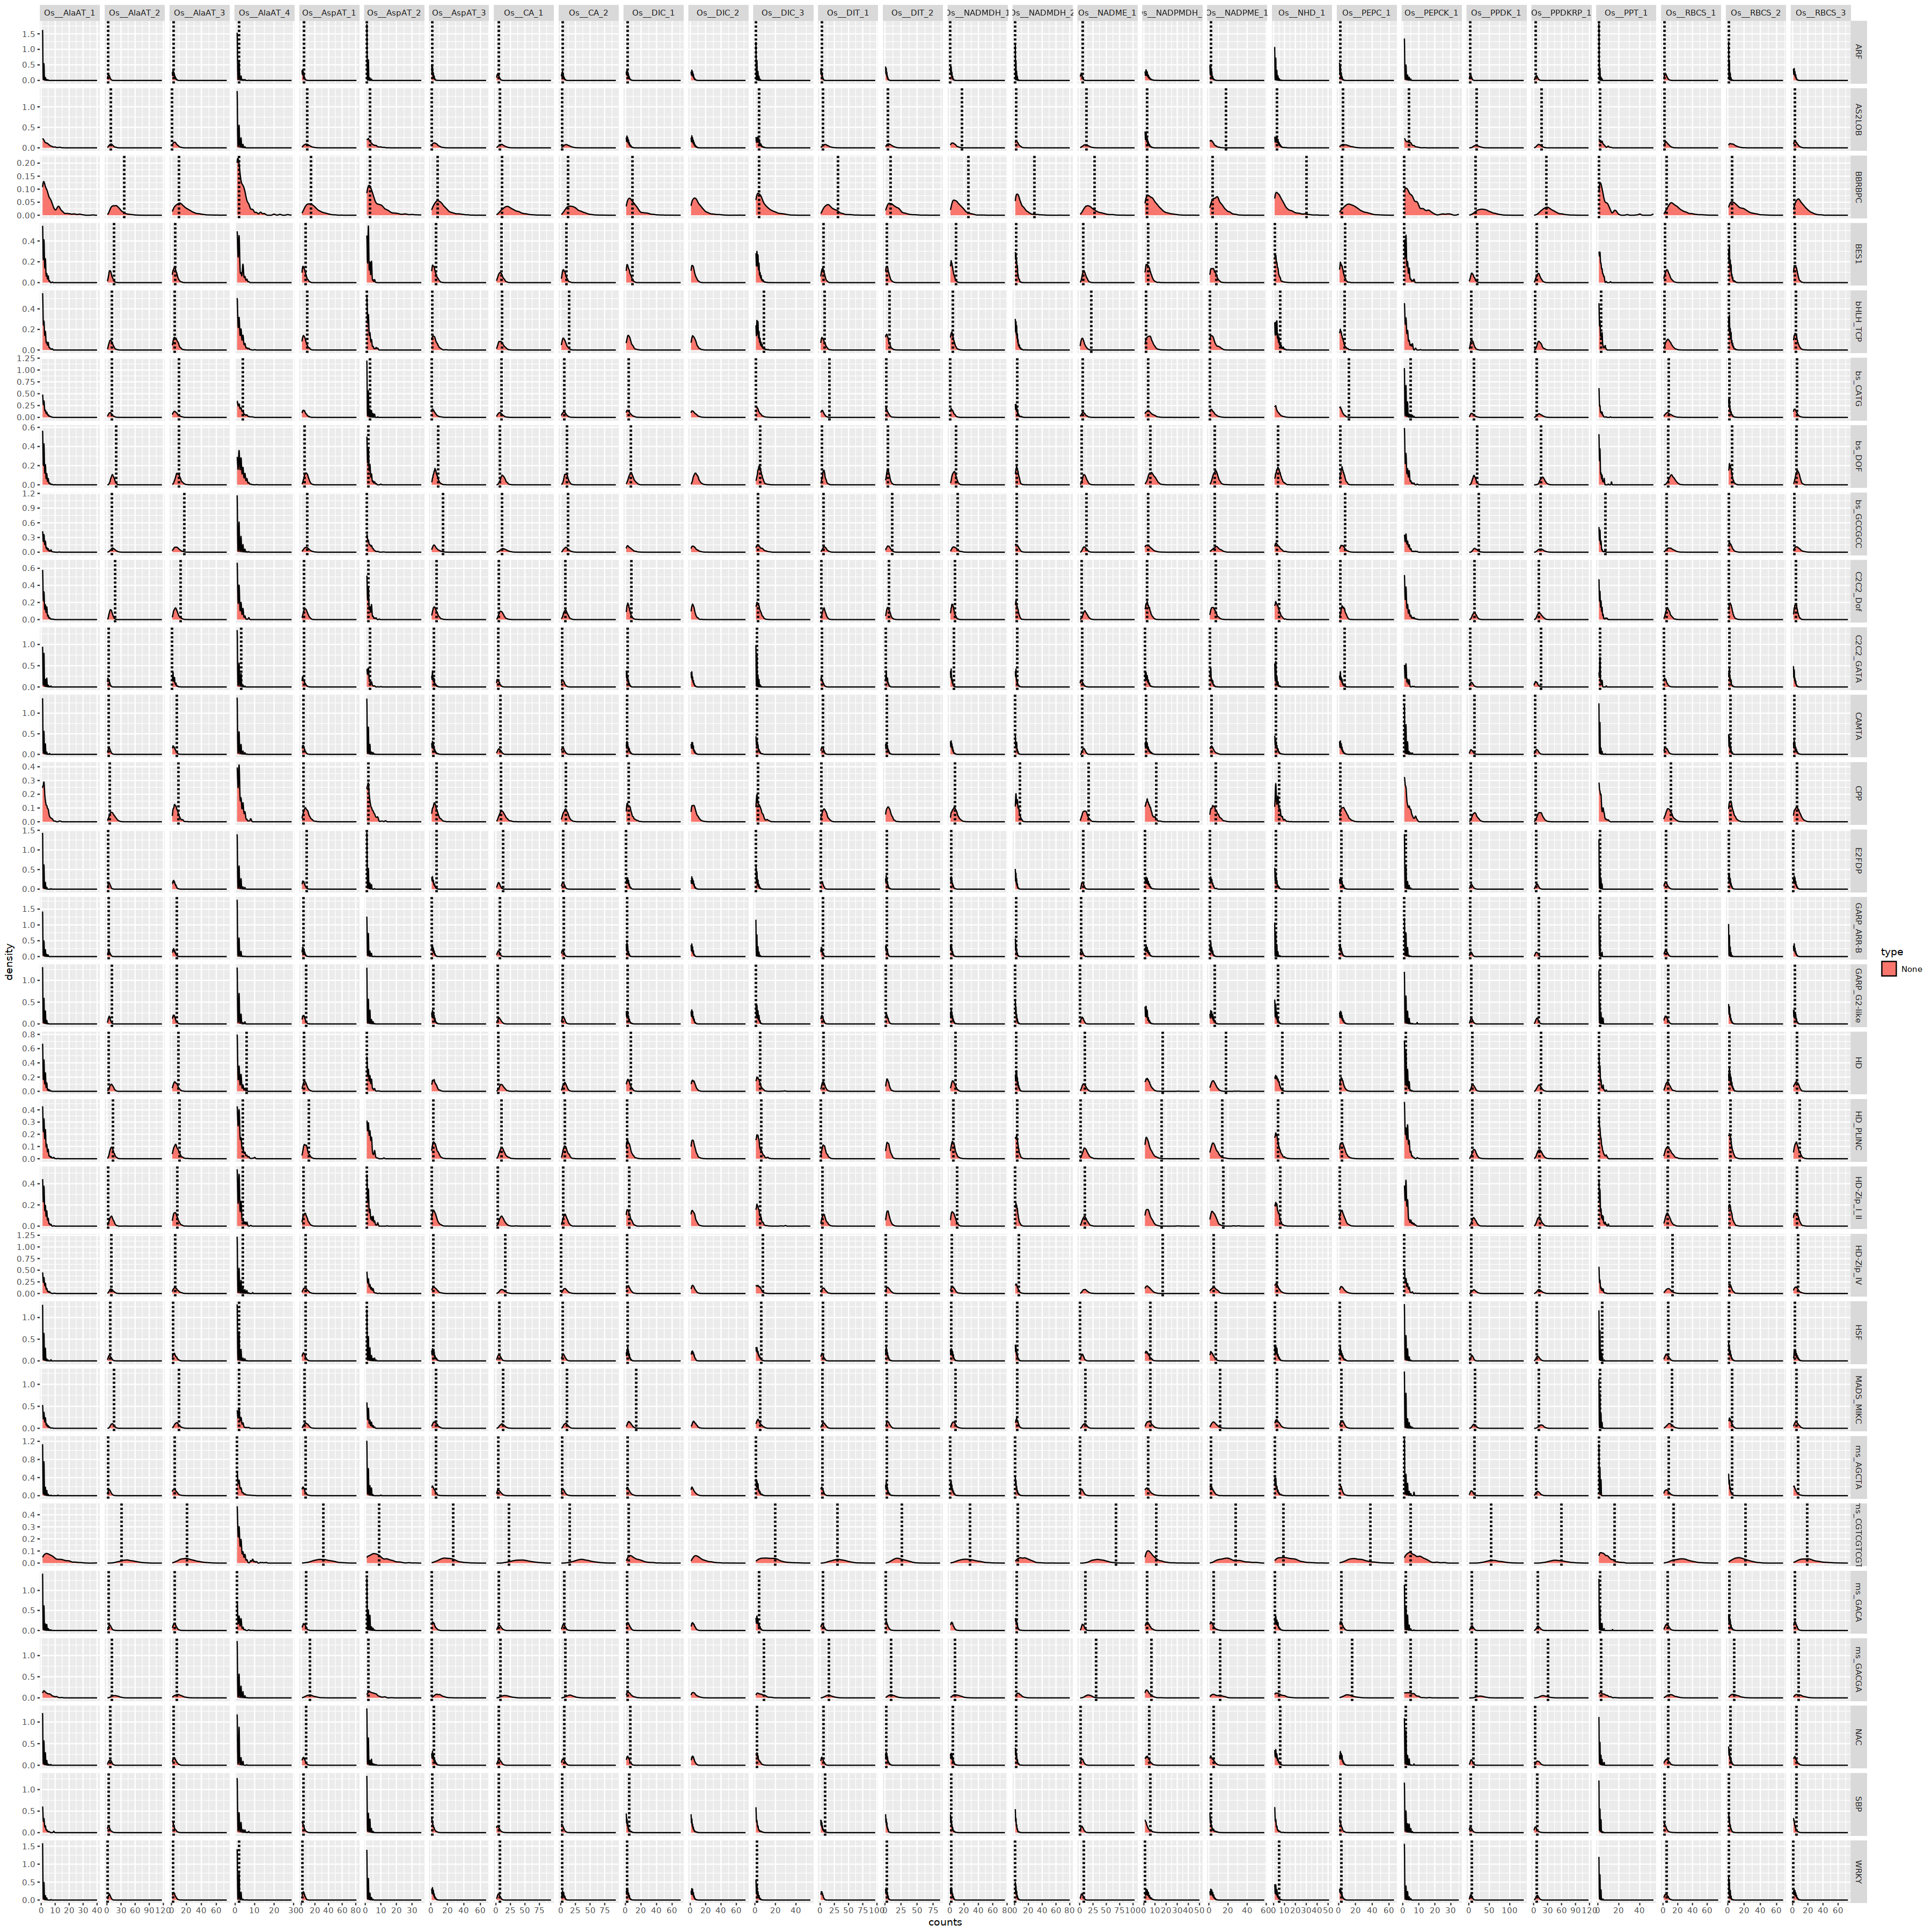

In [13]:

combined_df_models %>% 
    ggplot(., aes(x = counts, fill = type)) + 
    geom_density() + facet_grid(TF_ID~locus,   scales = "free") +
    geom_vline(data = plot_real_counts, 
               aes(xintercept=(counts)),
        linetype="dashed", size=1)